Уважаемый проверяющий, я знаю, что брал другой датасет, но для задачи кластеризации заданными методами мой датасет изображений не подходит. 
Я мог бы взять датасет IRIS, и показать понимание принципов на нём, но это было бы очень заезженно, поэтому я решил взять наудачу датасет Wine Quality. В итоге получилось не очень, но ведь и не на любых данных будет хорошо.

In [14]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6B8F71']


url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')

print(f"У нас есть {len(data)} бутылок вина")
print(f"И {len(data.columns)} характеристик у каждой бутылки")

print("\nПервые несколько бутылок, просто показать вид данных")
print(data.head(3))

print("\nКачество вина распределено:")
print(data['quality'].value_counts().sort_index())

У нас есть 1599 бутылок вина
И 12 характеристик у каждой бутылки

Первые несколько бутылок, просто показать вид данных
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  

Качество вина распределено:
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64


Характеристики вина: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol


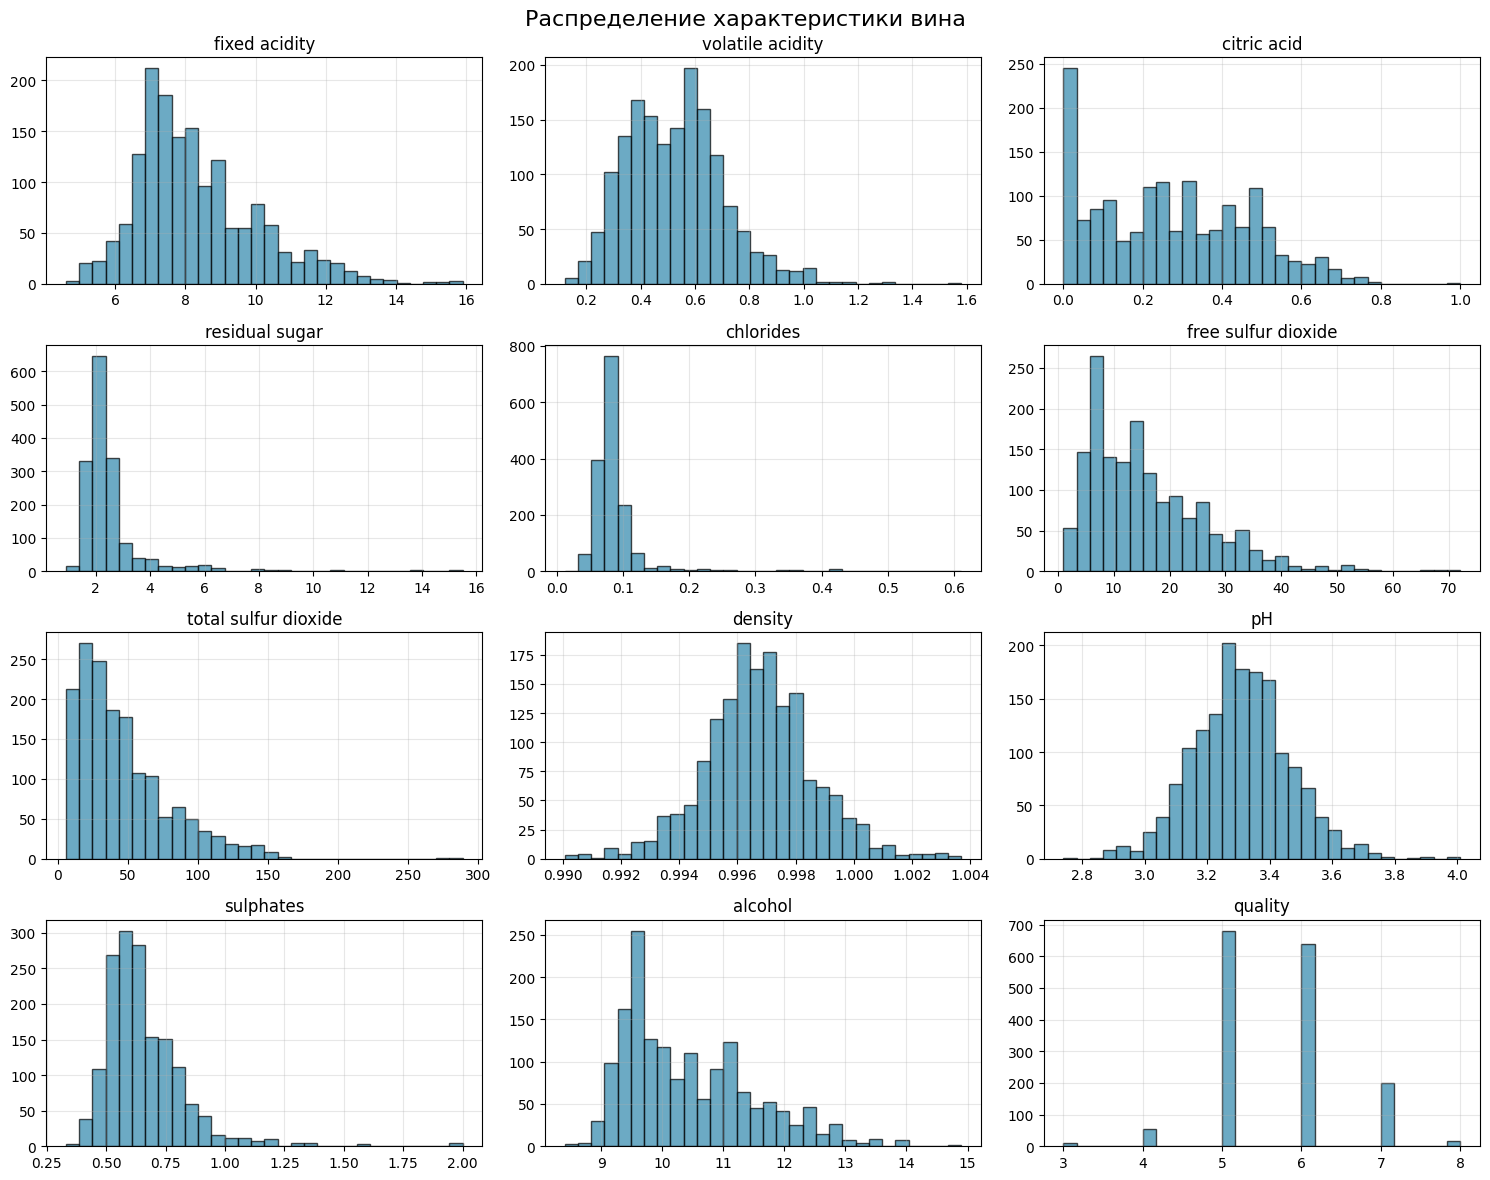

In [16]:
X = data.drop('quality', axis=1).values  # Только характеристики вина
y = data['quality'].values  # Только оценки качества

# Список что за характеристики
features = data.drop('quality', axis=1).columns.tolist()
print(f"Характеристики вина: {', '.join(features)}")

# Сначала посмотрим как данные выглядят
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten()

# Рисую гистограммы для каждой характеристики
for i, col in enumerate(data.columns):
    ax = axes[i]
    ax.hist(data[col], bins=30, color=colors[0], alpha=0.7, edgecolor='black')
    ax.set_title(col)
    ax.grid(True, alpha=0.3)

plt.suptitle('Распределение характеристики вина', fontsize=16)
plt.tight_layout()
plt.show()

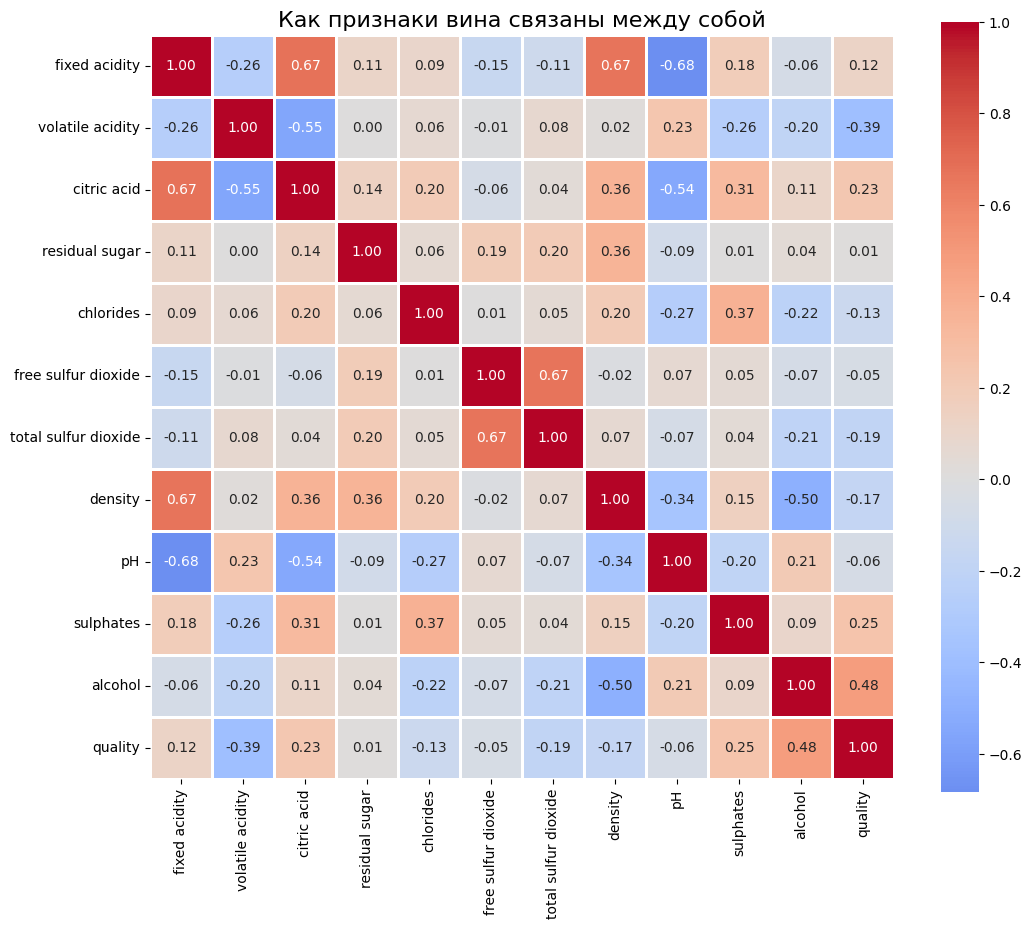


Что сильнее всего влияет на качество вина:
quality                 1.000
alcohol                 0.476
volatile acidity       -0.391
sulphates               0.251
citric acid             0.226
total sulfur dioxide   -0.185
density                -0.175
chlorides              -0.129
fixed acidity           0.124
pH                     -0.058
free sulfur dioxide    -0.051
residual sugar          0.014
Name: quality, dtype: float64


In [17]:
# Смотрю как признаки связаны друг с другом
plt.figure(figsize=(12, 10))
corr = data.corr()

# Тепловая карта корреляций
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Как признаки вина связаны между собой', fontsize=16)
plt.show()

# Какие признаки сильнее всего влияют на качество
print("\nЧто сильнее всего влияет на качество вина:")
quality_corr = corr['quality'].sort_values(key=abs, ascending=False)
print(quality_corr.round(3))

Первая компонента объясняет 28.2% изменчивости
Вторая компонента объясняет 17.5% изменчивости
Всего две компоненты объясняют 45.7% данных


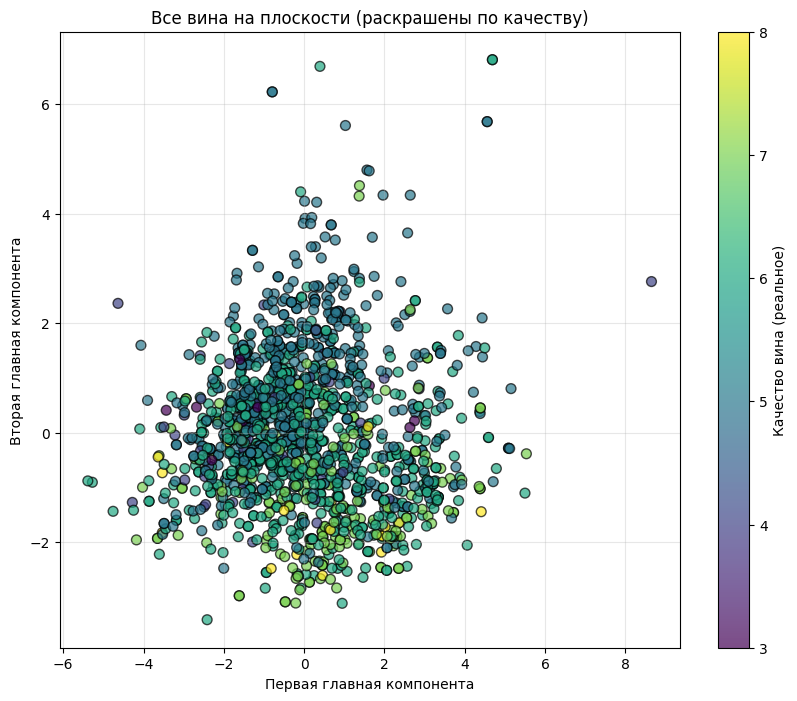

In [19]:
# Нормализуем
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Уменьшаем размерность 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Первая компонента объясняет {pca.explained_variance_ratio_[0]*100:.1f}% изменчивости")
print(f"Вторая компонента объясняет {pca.explained_variance_ratio_[1]*100:.1f}% изменчивости")
print(f"Всего две компоненты объясняют {sum(pca.explained_variance_ratio_)*100:.1f}% данных")

plt.figure(figsize=(10, 8))

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=y, cmap='viridis', 
                     s=50, alpha=0.7, edgecolor='k')
plt.colorbar(scatter, label='Качество вина (реальное)')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('Все вина на плоскости (раскрашены по качеству)')
plt.grid(True, alpha=0.3)
plt.show()

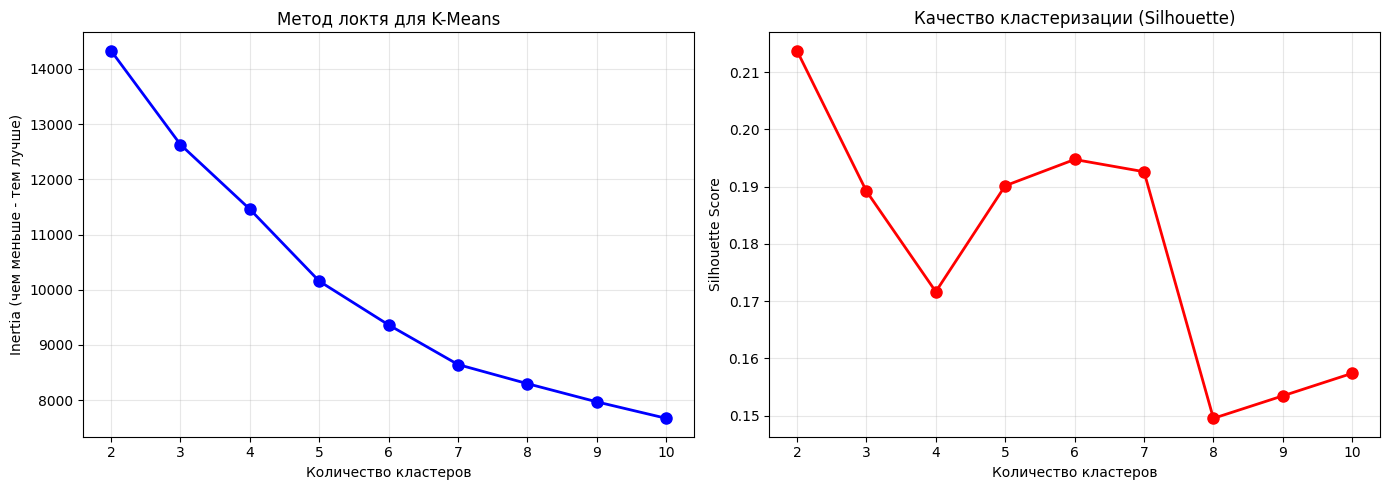

In [22]:
# Первый метод: K-Means

# Сколько кластеров имеет смысл брать
inertia_values = []
silhouette_values = []
k_range = range(2, 11)  # Пробуем от 2 до 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia_values.append(kmeans.inertia_)
    
    if len(set(labels)) > 1:
        silhouette_values.append(silhouette_score(X_scaled, labels))
    else:
        silhouette_values.append(0)

# Графики для выбора числа кластеров
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# График "локтя" - ищем изгиб
ax1.plot(k_range, inertia_values, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Количество кластеров')
ax1.set_ylabel('Inertia (чем меньше - тем лучше)')
ax1.set_title('Метод локтя для K-Means')
ax1.grid(True, alpha=0.3)

# График силуэта
ax2.plot(k_range, silhouette_values, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Количество кластеров')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Качество кластеризации (Silhouette)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

k_optimal = 6

kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(X_scaled)

Остановимся на шести кластерах

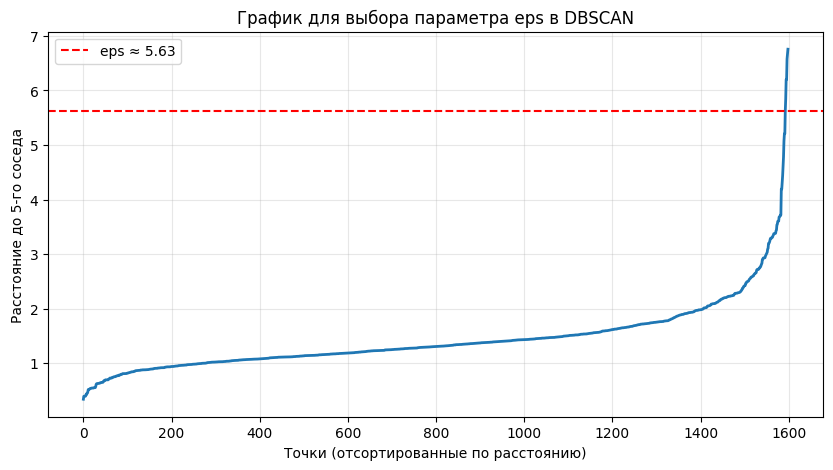

DBSCAN нашел 2 кластеров
И 187 точек посчитал шумом (11.7%)


In [23]:
# DBSCAN - ищем плотные области
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors.fit(X_scaled)
distances, _ = neighbors.kneighbors(X_scaled)

distances_sorted = np.sort(distances[:, 4])

plt.figure(figsize=(10, 5))
plt.plot(distances_sorted, linewidth=2)
plt.xlabel('Точки (отсортированные по расстоянию)')
plt.ylabel('Расстояние до 5-го соседа')
plt.title('График для выбора параметра eps в DBSCAN')
plt.grid(True, alpha=0.3)

# Ищем "изгиб" на графике
gradient = np.gradient(distances_sorted)
elbow_idx = np.argmax(gradient)
eps_value = distances_sorted[elbow_idx]

plt.axhline(y=eps_value, color='red', linestyle='--', 
            label=f'eps ≈ {eps_value:.2f}')
plt.legend()
plt.show()


dbscan_params = [
    {'eps': 1.8, 'min_samples': 5},
    {'eps': 2.0, 'min_samples': 5},
    {'eps': 2.2, 'min_samples': 5},
    {'eps': 2.5, 'min_samples': 5},
]

best_score = -1
best_labels = None

for params in dbscan_params:
    dbscan = DBSCAN(**params)
    labels = dbscan.fit_predict(X_scaled)
    

    unique_labels = set(labels)
    n_clusters = len([l for l in unique_labels if l != -1])
    
    if n_clusters > 1 and sum(labels != -1) > 50:
        valid_mask = labels != -1
        score = silhouette_score(X_scaled[valid_mask], labels[valid_mask])
        if score > best_score:
            best_score = score
            best_labels = labels

y_dbscan = best_labels if best_labels is not None else DBSCAN(eps=2.2, min_samples=5).fit_predict(X_scaled)

# Смотрю что получилось
unique_dbscan = set(y_dbscan)
n_clusters_dbscan = len([l for l in unique_dbscan if l != -1])
noise_count = sum(y_dbscan == -1)

print(f"DBSCAN нашел {n_clusters_dbscan} кластеров")
print(f"И {noise_count} точек посчитал шумом ({noise_count/len(y_dbscan)*100:.1f}%)")

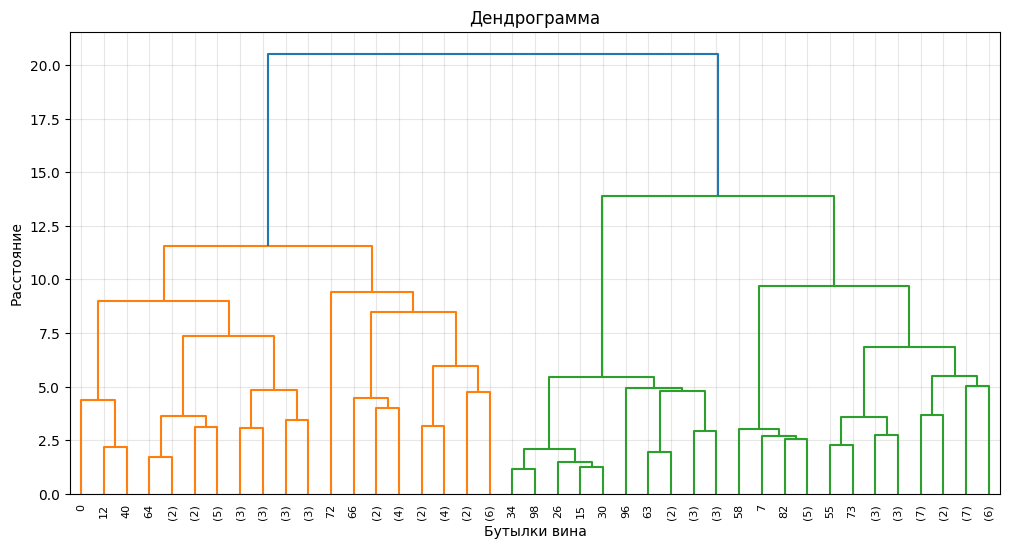

In [26]:
# Иерархическая кластеризация
agglo = AgglomerativeClustering(n_clusters=k_optimal, linkage='ward')
y_agglo = agglo.fit_predict(X_scaled)

# Дендрограмму на подвыборке
sample_size = 100
sample_idx = np.random.choice(len(X_scaled), sample_size, replace=False)

plt.figure(figsize=(12, 6))
Z = linkage(X_scaled[sample_idx], method='ward')

dendrogram(Z, truncate_mode='level', p=5)
plt.title('Дендрограмма')
plt.xlabel('Бутылки вина')
plt.ylabel('Расстояние')
plt.grid(True, alpha=0.3)
plt.show()

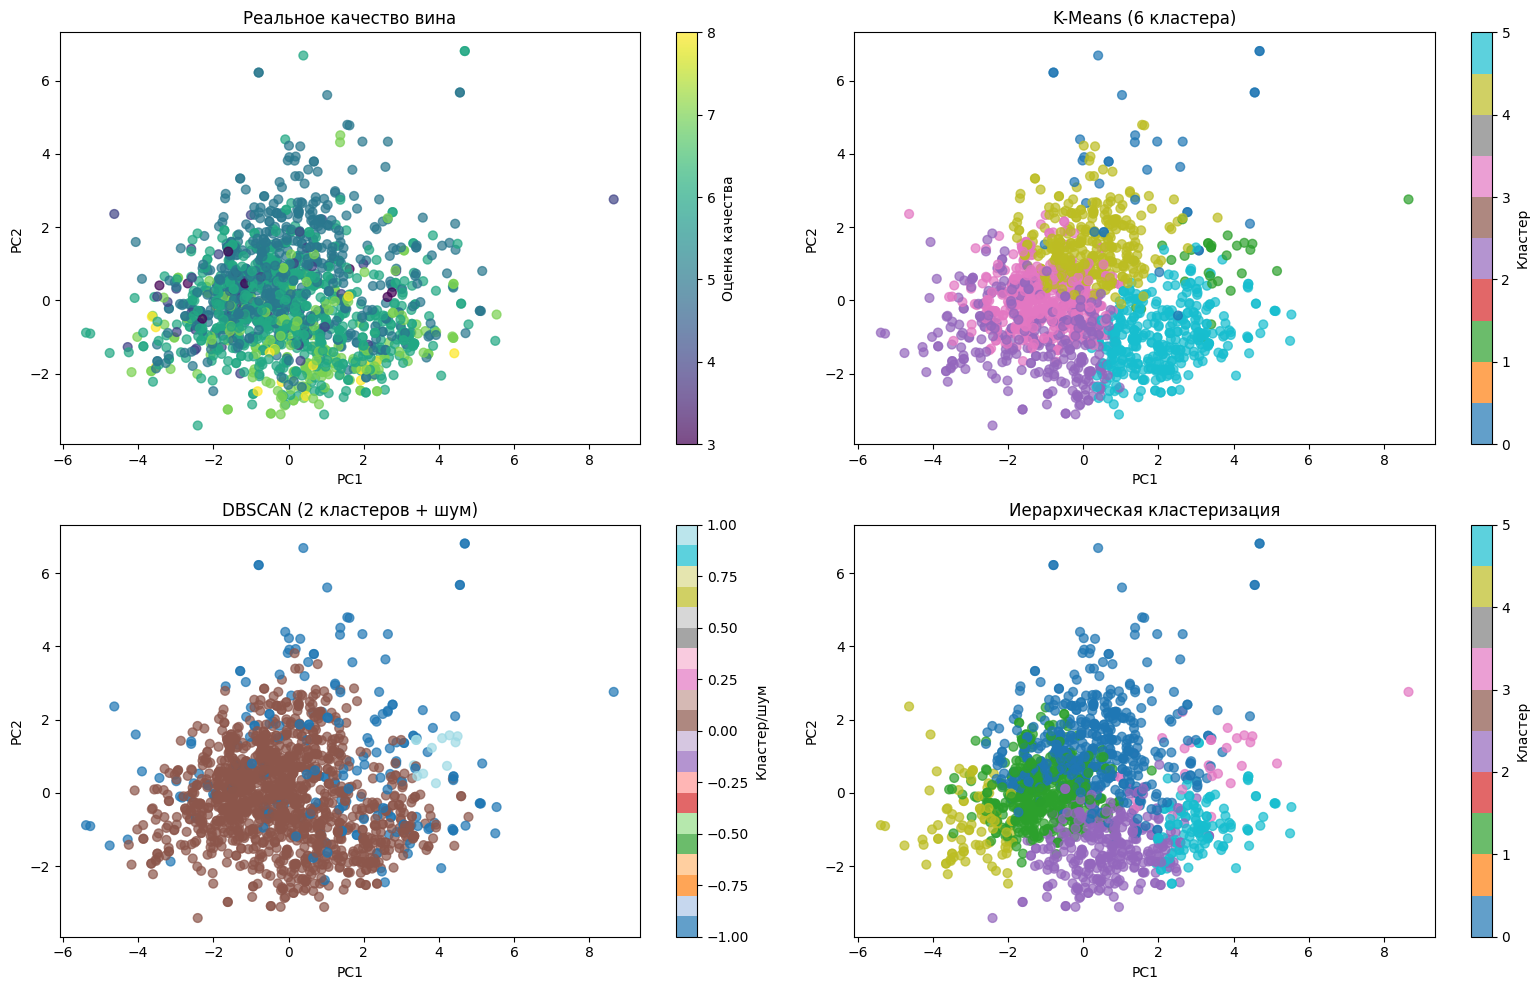

In [35]:
# Все результаты вместе
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Реальное качество
sc0 = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], 
                        c=y, cmap='viridis', s=40, alpha=0.7)
axes[0, 0].set_title('Реальное качество вина')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')
plt.colorbar(sc0, ax=axes[0, 0], label='Оценка качества')

# 2. K-Means кластеризация
sc1 = axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], 
                        c=y_kmeans, cmap='tab10', s=40, alpha=0.7)
axes[0, 1].set_title(f'K-Means ({k_optimal} кластера)')
axes[0, 1].set_xlabel('PC1')
axes[0, 1].set_ylabel('PC2')
plt.colorbar(sc1, ax=axes[0, 1], label='Кластер')

# 3. DBSCAN кластеризация
sc2 = axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], 
                        c=y_dbscan, cmap='tab20', s=40, alpha=0.7)
axes[1, 0].set_title(f'DBSCAN ({n_clusters_dbscan} кластеров + шум)')
axes[1, 0].set_xlabel('PC1')
axes[1, 0].set_ylabel('PC2')
plt.colorbar(sc2, ax=axes[1, 0], label='Кластер/шум')

# 4. Agglomerative кластеризация
sc3 = axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], 
                        c=y_agglo, cmap='tab10', s=40, alpha=0.7)
axes[1, 1].set_title('Иерархическая кластеризация')
axes[1, 1].set_xlabel('PC1')
axes[1, 1].set_ylabel('PC2')
plt.colorbar(sc3, ax=axes[1, 1], label='Кластер')


plt.tight_layout()
plt.show()

In [40]:
for cluster in range(k_optimal):
    mask = y_kmeans == cluster
    cluster_size = sum(mask)
    
    # Среднее качество вина в кластере
    avg_quality = y[mask].mean() if cluster_size > 0 else 0
    
    # Самые частые оценки качества
    unique_vals, counts = np.unique(y[mask], return_counts=True)
    most_common_idx = np.argmax(counts)
    most_common_quality = unique_vals[most_common_idx]
    
    print(f"\nКластер {cluster}:")
    print(f"  Количество вин: {cluster_size} ({cluster_size/len(y)*100:.1f}%)")
    print(f"  Среднее качество: {avg_quality:.2f}")
    print(f"  Чаще всего качество: {most_common_quality}")
    
    # типичные характеристики для этого кластера
    if cluster_size > 0:
        cluster_data = data[mask]
        print(f"  Характеристики (средние значения):")
        
        # 3 признака, которые отличаются больше всего
        overall_means = data.mean()
        cluster_means = cluster_data.mean()
        
        # Разница между кластером и общим средним
        differences = (cluster_means - overall_means).abs()
        top_features = differences.nlargest(3).index.tolist()
        
        for feature in top_features:
            cluster_val = cluster_means[feature]
            overall_val = overall_means[feature]
            diff_pct = ((cluster_val - overall_val) / overall_val) * 100
            print(f"    - {feature}: {cluster_val:.2f} ({diff_pct:+.1f}% от среднего)")


Кластер 0:
  Количество вин: 34 (2.1%)
  Среднее качество: 5.62
  Чаще всего качество: 5
  Характеристики (средние значения):
    - total sulfur dioxide: 102.24 (+120.0% от среднего)
    - free sulfur dioxide: 34.18 (+115.3% от среднего)
    - residual sugar: 9.53 (+275.5% от среднего)

Кластер 1:
  Количество вин: 30 (1.9%)
  Среднее качество: 5.33
  Чаще всего качество: 5
  Характеристики (средние значения):
    - total sulfur dioxide: 62.93 (+35.4% от среднего)
    - alcohol: 9.48 (-9.1% от среднего)
    - free sulfur dioxide: 14.97 (-5.7% от среднего)

Кластер 2:
  Количество вин: 302 (18.9%)
  Среднее качество: 6.16
  Чаще всего качество: 6
  Характеристики (средние значения):
    - total sulfur dioxide: 38.46 (-17.2% от среднего)
    - alcohol: 11.80 (+13.2% от среднего)
    - fixed acidity: 7.11 (-14.5% от среднего)

Кластер 3:
  Количество вин: 533 (33.3%)
  Среднее качество: 5.33
  Чаще всего качество: 5
  Характеристики (средние значения):
    - total sulfur dioxide: 33.09 (

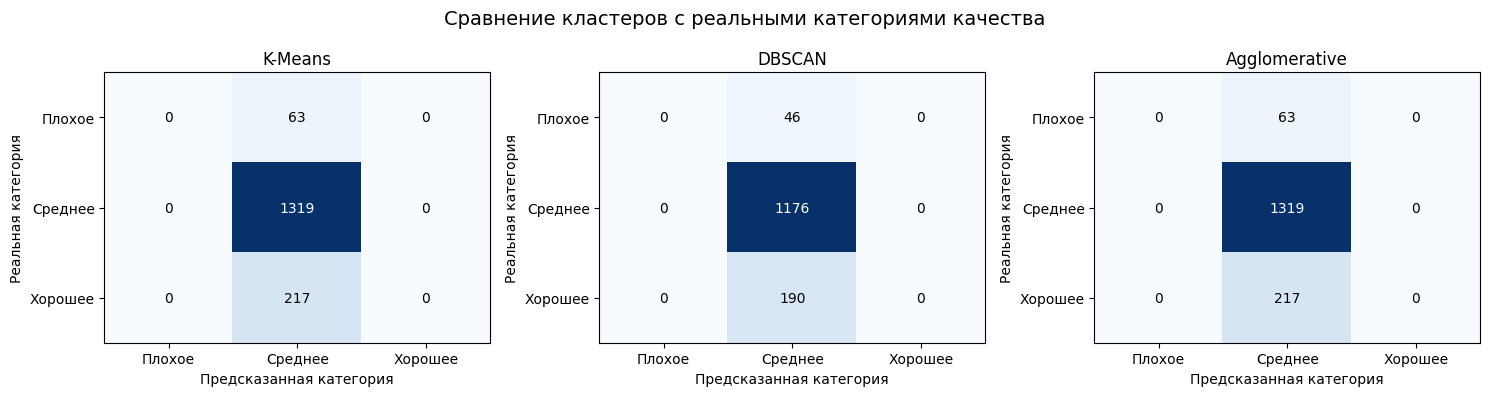

In [45]:
# Сравниваю кластеры с реальными оценками качества
# Преобразую качество в категории для сравнения
# Плохое (3-4), Среднее (5-6), Хорошее (7-8)
y_categories = np.zeros_like(y)
y_categories[y <= 4] = 0  # Плохое
y_categories[(y >= 5) & (y <= 6)] = 1  # Среднее
y_categories[y >= 7] = 2  # Хорошее

# Функция для сопоставления кластеров с категориями
def match_clusters_to_categories(cluster_labels, true_categories):
    matched_labels = np.zeros_like(cluster_labels)
    
    for cluster in np.unique(cluster_labels):
        if cluster == -1:  # Шум в DBSCAN
            continue
            
        mask = cluster_labels == cluster
        if sum(mask) > 0:
            # Какая категория чаще всего встречается в этом кластере
            true_in_cluster = true_categories[mask]
            unique, counts = np.unique(true_in_cluster, return_counts=True)
            most_common = unique[np.argmax(counts)]
            matched_labels[mask] = most_common
    
    return matched_labels

# Сопоставляю кластеры с категориями
y_kmeans_matched = match_clusters_to_categories(y_kmeans, y_categories)
y_agglo_matched = match_clusters_to_categories(y_agglo, y_categories)

# Для DBSCAN только не-шумовые точки
dbscan_valid = y_dbscan != -1
y_dbscan_matched = np.full_like(y_dbscan, -1)
if sum(dbscan_valid) > 0:
    y_dbscan_matched[dbscan_valid] = match_clusters_to_categories(
        y_dbscan[dbscan_valid], y_categories[dbscan_valid]
    )

# Матрицы ошибок
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, pred_labels, ax) in enumerate([
    ('K-Means', y_kmeans_matched, axes[0]),
    ('DBSCAN', y_dbscan_matched, axes[1]), 
    ('Agglomerative', y_agglo_matched, axes[2])
]):
    # Для DBSCAN только не шумовые точки
    if idx == 1:
        valid_mask = pred_labels != -1
        if sum(valid_mask) == 0:
            ax.text(0.5, 0.5, 'Все точки - шум', 
                   ha='center', va='center')
            ax.set_title(f'{name}')
            continue
            
        cm = confusion_matrix(y_categories[valid_mask], pred_labels[valid_mask])
    else:
        cm = confusion_matrix(y_categories, pred_labels)
    
    im = ax.imshow(cm, cmap='Blues', aspect='auto')
    ax.set_title(f'{name}')
    ax.set_xlabel('Предсказанная категория')
    ax.set_ylabel('Реальная категория')

    categories = ['Плохое', 'Среднее', 'Хорошее']
    ax.set_xticks(range(3))
    ax.set_yticks(range(3))
    ax.set_xticklabels(categories[:cm.shape[1]])
    ax.set_yticklabels(categories[:cm.shape[0]])
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            ax.text(j, i, str(cm[i, j]), 
                   ha='center', va='center', color=color)

plt.suptitle('Сравнение кластеров с реальными категориями качества', fontsize=14)
plt.tight_layout()
plt.show()

In [42]:
print("Качество разделения на кластеры")

quality_metrics = []
for method_name, labels in [('K-Means', y_kmeans), ('DBSCAN', y_dbscan), ('Agglomerative', y_agglo)]:
    unique_labels = set(labels)
    n_clusters = len([l for l in unique_labels if l != -1])
    
    valid_mask = labels != -1 if -1 in labels else np.ones_like(labels, dtype=bool)
    n_valid = sum(valid_mask)
    
    if n_clusters > 1 and n_valid > 10:
        silhouette = silhouette_score(X_scaled[valid_mask], labels[valid_mask])
    else:
        silhouette = 0
    
    quality_metrics.append({
        'Метод': method_name,
        'Silhouette': f'{silhouette:.3f}',
        'Кластеры': n_clusters,
        'Точек': len(labels)
    })

quality_df = pd.DataFrame(quality_metrics)
print(quality_df.to_string(index=False))

Качество разделения на кластеры
        Метод Silhouette  Кластеры  Точек
      K-Means      0.195         6   1599
       DBSCAN      0.572         2   1599
Agglomerative      0.150         6   1599


In [44]:
print("Параметры и характеристики методов")

method_params = []
for method_name, labels in [('K-Means', y_kmeans), ('DBSCAN', y_dbscan), ('Agglomerative', y_agglo)]:
    unique_labels = set(labels)
    n_clusters = len([l for l in unique_labels if l != -1])
    
    noise_pct = 0
    if -1 in labels:
        noise_pct = sum(labels == -1) / len(labels) * 100
    
    # Определяем тип метода
    method_type = {
        'K-Means': 'Центроидный',
        'DBSCAN': 'Плотностный', 
        'Agglomerative': 'Иерархический'
    }[method_name]
    
    # Основные параметры для каждого метода
    if method_name == 'K-Means':
        params = 'k=6'
    elif method_name == 'DBSCAN':
        params = f'eps≈2.2'
    else:  # Agglomerative
        params = 'linkage: ward, k=3'
    
    method_params.append({
        'Метод': method_name,
        'Тип': method_type,
        'Параметры': params,
        'Кластеры': n_clusters,
        'Шум, %': f'{noise_pct:.1f}'
    })

params_df = pd.DataFrame(method_params)
print(params_df.to_string(index=False))

Параметры и характеристики методов
        Метод           Тип          Параметры  Кластеры Шум, %
      K-Means   Центроидный                k=6         6    0.0
       DBSCAN   Плотностный            eps≈2.2         2   11.7
Agglomerative Иерархический linkage: ward, k=3         6    0.0


Выводы: как-то не очень получились результаты. Слабая кореллированность основных характеристик вина плохо позволила кластеризовать его стандартными методами, но проделана работа и переделывать всё то же с новым датасетом для более удачного разультата будет не очень корректно. В итоге получается, что почти все данные распознаются как среднее по качеству вино.